<ipython-input-12-3188dd9c6ba4>:68: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '_').str.replace(')', '').str.replace('<', '').str.replace('>','')
6


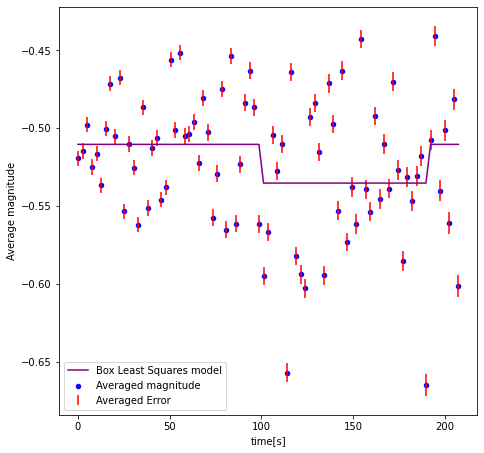

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u

from numpy import sqrt
from astropy.timeseries import BoxLeastSquares, TimeSeries
from astropy.time import Time
from scipy.signal import medfilt 

FILENAME = 'data.csv' # Change me to work with different files/filename
# FILENAME = 'wasp.xlsx'

def subtract_all_magnitudes(magnitudes: np.ndarray) -> np.ndarray:
    all_magnitudes_subtracted = [] # List so appending is not memory-intensive
    for index, column in enumerate(magnitudes.T): # Index so we can remove active column
        delta = np.delete(magnitudes, index, axis=1).T - column # Remove 'active' column, subtract active from every other column
        all_magnitudes_subtracted.append(delta)
    return np.array(all_magnitudes_subtracted) # Return np.array for modification later

def calculate_all_uncertainties(errors: np.ndarray) -> np.ndarray:
    all_uncertainties = [] # List so appending is not memory-intensive
    for index, column in enumerate(errors.T): # Index so we can remove active column
        uncertainty = sqrt(np.delete(errors, index, axis=1).T**2 + column**2) # Remove 'active' column, get uncertainty for each column
        all_uncertainties.append(uncertainty) 
    return np.array(all_uncertainties) # Return np.array for modification later

def normalize(data: np.ndarray) -> np.ndarray:
    data_min = np.min(data)
    data_max = np.max(data)
    normalized = (data-data_min)/(data_max - data_min)
    return normalized

def box_model_data(data: np.ndarray, exposure_time: float, uncertainties: np.ndarray) -> np.ndarray:
    samples = data.shape[1]
    time = np.linspace(0, samples*exposure_time, samples)*u.second
    time_middle = np.median(time)-(5*u.second) # to push it to a single giant tophat
    durations = np.linspace(time_middle/5, time_middle, 15)
    accumulated_results = []
    
    for i, sample in enumerate(data):
        uncertainty = uncertainties[i]
        model = BoxLeastSquares(time, sample, uncertainty)
        periodogram = model.autopower(durations, frequency_factor=15)
        index = np.argmax(periodogram.power)
        period = periodogram.period[index]
        t0 = periodogram.transit_time[index]
        duration = periodogram.duration[index]
        stats = model.compute_stats(period, duration, t0)
        model_fit = model.model(time, period, duration, t0)

        if(stats['transit_times'].size == 1):
            result = {'name': i,
                    'best_fit_values': {'index': index, 'period': period, 'transit_time':t0, 'duration': duration},
                    'data': sample,
                    'uncertainty': uncertainty,
                    'stats': stats,
                    'fitted_model': model_fit,
                    'time': time}
            accumulated_results.append(result)
    
    return np.array(accumulated_results)


df = pd.read_csv(FILENAME)
# df = pd.read_excel(FILENAME)

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '_').str.replace(')', '').str.replace('<', '').str.replace('>','')
# Cleanup of headers, could be made more succinct with a simple REGEX
df = df[['obj', 'mag', 'error', 'error_t', 's/n']] #Reduce to what we need

mags = df['mag'].to_numpy()
error = df['error_t'].to_numpy()

rows = df.shape[0]
num_stars = df['obj'].nunique() # so we know how many stars we're working with
samples = int(rows/num_stars)   # Need this so we know how many files we're working with

mags = np.reshape(mags, (samples, num_stars))      # Stack both mags and error according to time, new column = new file in time
error = np.reshape(error, (samples, num_stars))
diff_mags = subtract_all_magnitudes(mags)          # array of arrays, each array corresponding to a single star as the 'target'
uncertainties = calculate_all_uncertainties(error) # Each individual array is organized by incrementing time in columns, rows are stars
average_diff_mags = np.mean(diff_mags, axis=1, dtype=np.float64) # mean of every column, accumulating all stars at particular time
average_uncertainties = sqrt(np.sum(uncertainties**2, axis=1, dtype=np.float64))/uncertainties[0].shape[0] # sum of squares of each column, then sqrt'd

box_model_results = box_model_data(average_diff_mags, 2.5, average_uncertainties)

test_index = 2
test_data = box_model_results[test_index]
test_mag = test_data['data']
test_uncert = test_data['uncertainty']
test_model = test_data['fitted_model']
test_time  = test_data['time']
print(test_data['name'])

# Plotting and whatnot
test_df = pd.DataFrame({'average_magnitude': test_mag, 'average_uncertainty': test_uncert, 'time': test_time})
ax = test_df.plot.scatter(x='time', y='average_magnitude', color='b', figsize=(7.5, 7.5), label='Averaged magnitude')
ax.plot(test_time, test_model, label='Box Least Squares model', color='purple')
ax.errorbar(x=test_df['time'], y=test_df['average_magnitude'], yerr=test_df['average_uncertainty'], fmt='none', color='r', label='Averaged Error')
ax.set_xlabel('time[s]')
ax.set_ylabel('Average magnitude')
ax.legend()
